## Note
Trying out different models and paramaters to see which performs the best

In [582]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

In [610]:
# Loading the evaluation data
dev = pd.read_csv("../csv_files/development.csv")

In [611]:
# Extracting the positions and removes the x and y column.
import numpy as np
pos_dev = dev[["x", "y"]]

## Dropping data from x and y 
dev = dev.drop(["x", "y"], axis=1)

In [612]:
## Removing pads with format: pads = [0, 7, 12, ..]
def drop_pads(input_list, df):
    for i in input_list:
        columns_to_remove = df.filter(like=f'[{i}]').columns
        df = df.drop(columns=columns_to_remove)
    return df

remove_pads = [0, 7, 12, 15, 16, 17]
dev_removed_noise = drop_pads(remove_pads, dev)

In [613]:
## Removing rms feature
def drop_rms_features(df):
    # Extract columns that start with 'rms'
    rms_columns = [col for col in df.columns if not col.startswith('rms')]

    # Create a new DataFrame without 'rms' columns
    df_without_rms = df[rms_columns] 
    return df_without_rms

dev_interesting_data = drop_rms_features(dev_removed_noise)

In [614]:
## Z-transformation of the data. Remember to scale accordingly to training data for eval data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(dev_interesting_data)
 
dev_interesting_data = pd.DataFrame(scaler.transform(dev_interesting_data), columns=dev_interesting_data.columns)

In [615]:
# def quantile2(dframe, lw=0.05, up=0.95, drop=True):
#     tresholds = {}
#     for col_name in dframe.columns:
#         lw_tresh = dframe[col_name].quantile(lw)
#         up_tresh = dframe[col_name].quantile(up)
#         tresholds[col_name] = [lw_tresh, up_tresh]
#     print(f"tresholds for {lw}, {up}: {tresholds}")
#     initial_dim = dframe.shape
#     for col_name in dframe.columns:
#         if drop:
#             dframe.drop(dframe[dframe[col_name] < tresholds[col_name][0]].index, inplace=True)
#             dframe.drop(dframe[dframe[col_name] > tresholds[col_name][1]].index, inplace=True)
#         else:
#             dframe.loc[dframe[col_name] < tresholds[col_name][0], col_name] = tresholds[col_name][0]
#             dframe.loc[dframe[col_name] > tresholds[col_name][1], col_name] = tresholds[col_name][1]

#     new_dim = dframe.shape
#     print(f"""
#           initial dim:   {initial_dim}
#           new dim:       {new_dim}
#           a reduction of {((initial_dim[0]-new_dim[0])/initial_dim[0])*100}% of rows
#           """)
    
# quantile2(dev_interesting_data, drop=True, lw=0.01, up=0.99)

In [618]:
# ## Reducing the dataset to X percent of original size to speed up model testing
dev_interesting_data_sample = dev_interesting_data.sample(frac=0.3)
pos_dev_sample = pos_dev.loc[dev_interesting_data_sample.index]

In [619]:
print(len(dev_interesting_data_sample), len(pos_dev_sample))

115650 115650


In [624]:
## Splitting into train and validation set
X_train, X_val, pos_train, pos_val = train_test_split(dev_interesting_data_sample, pos_dev_sample, test_size=0.2, random_state=42)

In [627]:
x_train_data = []
y_train_data = []
for i in range(len(pos_train)):
    x_train_data.append(pos_train.values[i][0])
    y_train_data.append(pos_train.values[i][1])

## RandomForestRegressor

In [628]:
# RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import math
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

numb_trees = 25
# base_regressor = RandomForestRegressor(n_estimators=numb_trees, criterion="poisson", max_depth=30, max_features=0.3, bootstrap=True) 
# mult_regr = MultiOutputRegressor(base_regressor)

mult_regr_x = RandomForestRegressor(n_estimators=numb_trees, criterion="poisson", random_state=42, max_features=0.3)
mult_regr_y = RandomForestRegressor(n_estimators=numb_trees, criterion="poisson", random_state=42, max_features=0.3)

mult_regr_x.fit(X_train, x_train_data)
mult_regr_y.fit(X_train, y_train_data)

importance_x = mult_regr_x.feature_importances_
importance_y = mult_regr_y.feature_importances_
# mult_regr.fit(X_train, pos_train)


# pos_pred = mult_regr.predict(X_val)

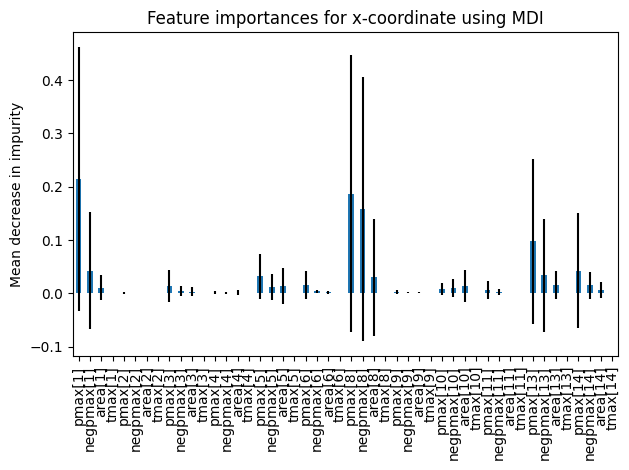

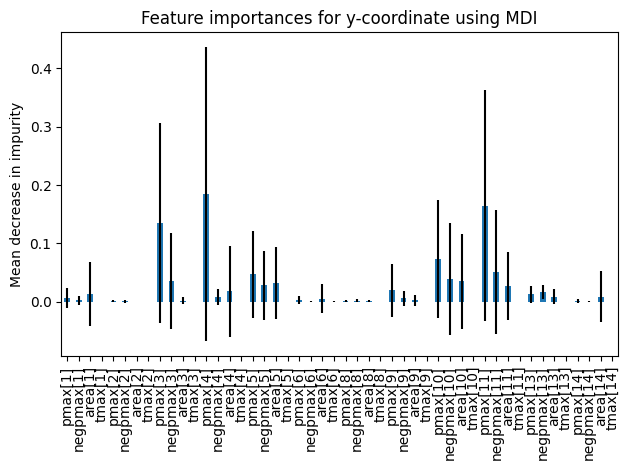

In [638]:
importances_x = mult_regr_x.feature_importances_
std = np.std([tree.feature_importances_ for tree in mult_regr_x.estimators_], axis=0)

forest_importances_x = pd.Series(importances_x, index=dev_interesting_data_sample.columns)
fig, ax = plt.subplots()
forest_importances_x.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances for x-coordinate using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

importances_y = mult_regr_y.feature_importances_
std = np.std([tree.feature_importances_ for tree in mult_regr_y.estimators_], axis=0)

forest_importances_y = pd.Series(importances_y, index=dev_interesting_data_sample.columns)
fig, ax = plt.subplots()
forest_importances_y.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances for y-coordinate using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


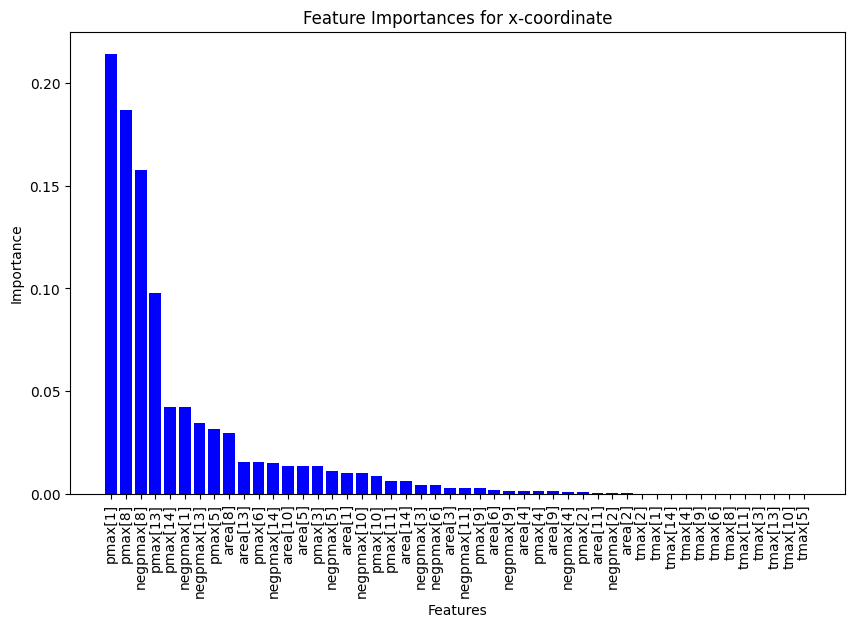

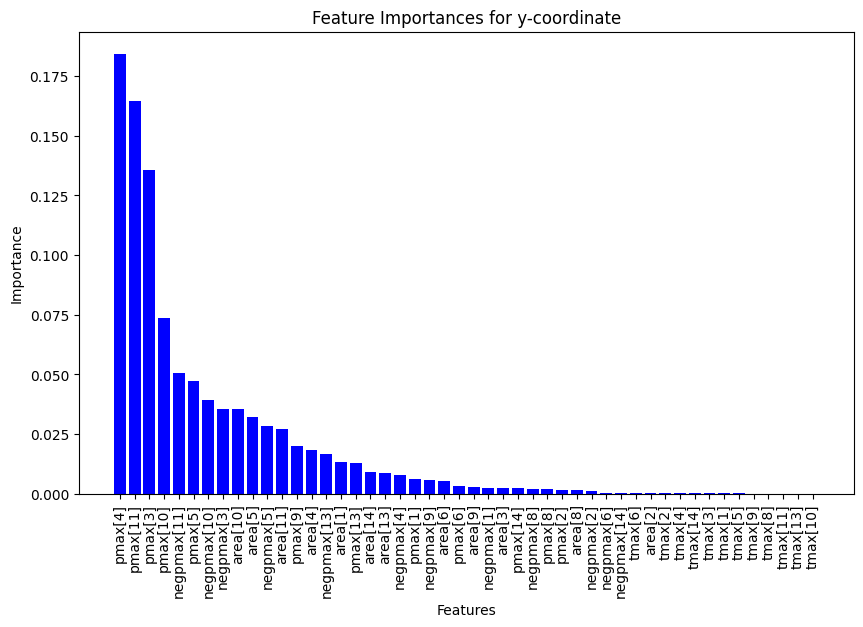

In [640]:
# Convert the importances into a DataFrame
feature_importances_x = pd.DataFrame({'feature': X_train.columns, 'importance': importances_x})

# Sort the DataFrame by importance
feature_importances_x = feature_importances_x.sort_values('importance', ascending=False)

# Plotting
plt.figure(figsize=(10,6))
plt.title('Feature Importances for x-coordinate')
plt.bar(feature_importances_x['feature'], feature_importances_x['importance'], color='b')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation='vertical')
plt.show()


# Convert the importances into a DataFrame
feature_importances_y = pd.DataFrame({'feature': X_train.columns, 'importance': importances_y})

# Sort the DataFrame by importance
feature_importances_y = feature_importances_y.sort_values('importance', ascending=False)

# Plotting
plt.figure(figsize=(10,6))
plt.title('Feature Importances for y-coordinate')
plt.bar(feature_importances_y['feature'], feature_importances_y['importance'], color='b')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation='vertical')
plt.show()

## Note on GridSearchCV
By splitting the problem into a regression problem for x-coordinate and y-coordinate I used GridSearchCV with these paramaters:
   
    param_grid = {  
        'max_depth': [20, 30, 40],  # Maximum depth of the tree
        'min_samples_split':[2, 4, 6], # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 4], # Minimum number of samples required to be at a leaf node
        'max_features': ["sqrt", "log2", None]
        }  
         
The best paramaters for x-coordinate and y-coordinate were: 
  
{'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}  
{'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4}  

 
 This GridSearch is run on only 1% of the dataset in order to speed up the process.



In [608]:
# Metrics to evaluating model 
import sklearn.metrics as sm
import math
import numpy as np

def avg_euc_dist(pos_val, pos_pred):
    sum_square = 0
    for i in range(len(pos_val)):
        sum_square += math.sqrt((pos_val[i][0]-pos_pred[i][0])**2 + (pos_val[i][1]-pos_pred[i][1])**2)
    return sum_square/len(pos_val)    

def metrics_on_model(pos_val, pos_pred):
    print("Mean absolute error =", round(sm.mean_absolute_error(pos_val, pos_pred), 2)) 
    print("Mean squared error =", round(sm.mean_squared_error(pos_val, pos_pred), 2)) 
    print("Median absolute error =", round(sm.median_absolute_error(pos_val, pos_pred), 2)) 
    print("Explain variance score =", round(sm.explained_variance_score(pos_val, pos_pred), 2)) 
    print("R2 score =", round(sm.r2_score(pos_val, pos_pred), 2))
    print("Mean eucledian distance =", round(avg_euc_dist(pos_val, pos_pred), 2))

metrics_on_model(pos_val.to_numpy(), pos_pred)

Mean absolute error = 3.19
Mean squared error = 18.09
Median absolute error = 2.5
Explain variance score = 1.0
R2 score = 1.0
Mean eucledian distance = 5.03


## Results:

Test 1:  
    Data: reomving pads (0, 7, 12, 15, 16, 17)  
    Number of trees: 10   
    Mean euc dist: 5.77  

Test 2:  
    Data: reomving pads (0, 7, 12, 15, 16, 17) and removing rms feature  
    Number of trees: 10  
    Mean euc dist: 5.69

Test 3:    
    Data: Sampeled 25% of the data to speed up model training. Reomving pads (0, 7, 12, 15, 16, 17) and removing rms feature.  
    Number of trees: 10  
    Mean euc dist: 6.56  

Test 4:    
    Data: Sampeled 25% of the data to speed up model training. Reomving pads (0, 7, 12, 15, 16, 17) and removing rms feature.  
    Number of trees: 30  
    Mean euc dist: 6.16  

Test 4:    
    Data: With PCA. Sampeled 25% of the data to speed up model training. Reomving pads (0, 7, 12, 15, 16, 17) and removing rms feature.  
    Number of trees: 30  
    Mean euc dist: 10.29

Test 5:        
    Data: Reomving pads (0, 7, 12, 15, 16, 17) and removing rms feature. Added RobustScaling.   
    Number of trees: 50  
    Mean euc dist: 5.31  

Test 6:  
    Data: Reomving pads (0, 7, 12, 15, 16, 17) and removing rms feature. Added column: pmax[5]*area[5] 
    Number of trees: 30  
    Mean euc dist: 6.11

Test 7:   
    Data: Reomving pads (0, 7, 12, 15, 16, 17) and removing rms feature.  
    Number of trees: 25  
    Mean euc dist: 6.58  

 

## Using the multiple_reg_model on the evaluation set

In [576]:
ev_data = pd.read_csv("../csv_files/evaluation.csv")

In [577]:
# Extracting the ID
eval_id = ev_data["Id"]

# Dropping the Id column from the ev_data
ev_data = ev_data.drop(["Id"], axis=1)

In [578]:
# Formatting the position array to a string to be used in the .csv file 
def pred_to_string(prediction_array):
    pred_column = []
    for i in range(len(prediction_array)):
        pos_string = (str(prediction_array[i][0]) + "|" + str(prediction_array[i][1]))
        pred_column.append(pos_string)
    return pred_column
        

In [579]:
## Preprocessing 
remove_pads = [0, 7, 12, 15, 16, 17]
ev_data = drop_pads(remove_pads, ev_data) # Remove pads
ev_data = drop_rms_features(ev_data) # Remove rms feature 
ev_data = pd.DataFrame(scaler.transform(ev_data), columns=ev_data.columns) # Z-transform with mean and std from training data

In [580]:
# Predicting the evaluation results
mult_regr_eval = mult_regr.predict(ev_data)
pos_pred = pred_to_string(mult_regr_eval) # Formatting the predictions 

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- area[0]
- area[10]
- area[12]
- area[15]
- area[16]
- ...


In [581]:
# Creating a df and .csv file to be submitted. Saved in submission_file folder
mult_reg_submission = pd.DataFrame({'Id': eval_id, 'Predicted': pos_pred})
mult_reg_submission.to_csv("../DataScienceLab_Project/submission_files/mult_reg_rand_forest_tuned_hyperparam_z_score_correct_pads.csv", index=False)

ValueError: Per-column arrays must each be 1-dimensional